# COGS108 - Final Project

## Team Members:
- A13712124: Yaobang Deng 
- A14057703: Jiaxiao Zhou 
- A92048017: Yuqi Kang
- A13801210: Zhongyu Chen 
- A14128051: Yiming Zhang 

# Introduction and Background

### Background:

As we all know, winning Oscar boosts a movie’s reputation hugely. Best picture award is always deemed as a quality-guarantee for a movie. However, most of the time, public's taste seem to differ from the Oscar's: many oscar winning movies are suprisingly obsure to the public and only when they win the Oscar would people be able to recognize them. This leave us to ponder on a question: is an award still valuable if it is not representing the public opinion? Therefore, by analyzing rating and other attributes of the movies over the past 10 years, we want to get some insight on the correlation of public rating, critic rating and the Oscar awards. 

References:
- 1) https://www.quora.com/What-is-the-lowest-IMDb-rated-movie-that-won-an-Oscar
- 2) http://www.metacritic.com/feature/how-often-does-the-best-film-win-the-best-picture-oscar

- The first reference lists out the worst oscar-winning movies' rating on IMDB (particularly, those whose rating were under 7.0), giving us a visualization on how large the portion of moderate-rated movies actually won the Oscar best picture. Deducing from the fact that no best picture get a rating lower than 7.2 ever since 1964, we predict that the best picture are usually not too bad in terms of viewers' taste. 
- However, as the second reference points out, the chance of the highest rating movies on IMDB winning the Academy Award is as low as 15%. This leads us to another prediction that high rating from the viewers does not garantee an Oscar best picture award. 

### Research Question:
What is the relationship between the public reviews of the movie and the authorities views of the movie? 

More specifically, do Oscar-winning-and-nomineeing movies always get positive feedbacks from its viewers or the correlations will be different under different movie genres or revenues?

### Hypothesis: 
We predict that the Oscar award does not have a strong relationships with the viewers ratings. In other words, the winners of Academy award for the best picture, though almost never get too low in rating, were usually not listed the highest on IMDB that year, while the IMDB most favorable movies seldom ended up winnning the best picture award.

# Data Description

#### Dataset Name: IMDB-Movie-Data

This dataset contains the information of 1000 movies produced from 2006 to 2016. 
Each data row has the following columns:
    Title; Genre; Description; Directors; Actors; Year; Runtime; Rating; Votes; Revenue; Metascore.

Link to the dataset: https://www.kaggle.com/PromptCloudHQ/imdb-data

For our research question, we choose to use these columns:
1. Title - moive name
2. Genre
3. Year - the year the moive is produced, as a time indicator when we do data cleaning
4. Rating - the public review
5. Revenue
6. Metascore - moive critic rating

The deficiency of this dataset is that it has some empty cells.


#### Dataset Name: database

This dataset contains the information of 9965 movies that are in the range of nomination of Oscar ( Academy ) award from 1927 to 2015.
Each data row has the following columns:
    Year; Ceremony; Award; Winner; Name; Film

Link to the dataset: https://www.kaggle.com/theacademy/academy-awards/data

For our research question, we choose to use these columns:
1. Year - the year of Oscar award/the moive was produced
2. Ceremony - used as a filter for year, to the time of moives in this dataset correspond to that in IMDB
2. Award - the type of award
3. Winner - whether or not the nominated moive is the winner, denoted by 1
4. Name - the actor name/the moive title
5. Film - the moive title/the actor name
    
This dataset is not as clean and organized as the IMDB dataset. Besides having empty cells and garbage characters, there are three major concerns in this dataset:
1. The name of movies could be either in the Name column or in the Film column, depending on the type of Award
2. When the Award is about music, the actual movie name is presented in the following format:
        "XXXX(Song name)" from XXXX(Moive name)
3. There are some types of awards which is not for a certain movie

In [99]:
#import stuffs
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import IPython

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Data Cleaning/Pre-Processing

### Part 1: IMDB

In [100]:
# load imdb dataset
IMDB_path = "IMDB-Movie-Data.csv"
IMDB_dataset = pd.read_csv(IMDB_path)

IMDB_dataset.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [101]:
# drop irrevalent columns
IMDB_dataset.drop(axis=1, labels=['Rank','Description'], inplace=True)

# rename the columns
IMDB_dataset.columns = ['title','genre','director','actors','year','duration','rate','votes','revenue','meta']

# drop the rows whose meta score is null
IMDB_dataset.dropna(inplace=True,subset=['meta'])

# drop 2016 movies in IMDB since they don't appear in Oscar dataset
IMDB_dataset = IMDB_dataset[IMDB_dataset['year'] != 2016]

# reset the row index
IMDB_dataset.reset_index(drop=True,inplace=True)

# scale the rate column up by a factor of 10
IMDB_dataset['rate'] = IMDB_dataset['rate'] * 10

IMDB_dataset.head()

,title,genre,director,actors,year,duration,rate,votes,revenue,meta
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,81.0,757074,333.13,76.0
1,Prometheus,"Adventure,Mystery,Sci-Fi",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,70.0,485820,126.46,65.0
2,Interstellar,"Adventure,Drama,Sci-Fi",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,86.0,1047747,187.99,74.0
3,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",Rob Marshall,"Johnny Depp, Penélope Cruz, Ian McShane, Geoff...",2011,136,67.0,395025,241.06,45.0
4,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Fantasy",J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...",2015,136,81.0,661608,936.63,81.0


In [102]:
# function that strip the white space of the string
def strip(name) :
    return str(name).strip()

In [103]:
# function that turn string to lower case
def lower(name):
    return str(name).lower()

In [104]:
# Strip the leading and ending white space in title column
IMDB_dataset["title"] = IMDB_dataset["title"].apply(strip)

# Transform the title column into all lower case
IMDB_dataset["title"] = IMDB_dataset["title"].apply(lower)

IMDB_dataset.head()

,title,genre,director,actors,year,duration,rate,votes,revenue,meta
0,guardians of the galaxy,"Action,Adventure,Sci-Fi",James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,81.0,757074,333.13,76.0
1,prometheus,"Adventure,Mystery,Sci-Fi",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,70.0,485820,126.46,65.0
2,interstellar,"Adventure,Drama,Sci-Fi",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,86.0,1047747,187.99,74.0
3,pirates of the caribbean: on stranger tides,"Action,Adventure,Fantasy",Rob Marshall,"Johnny Depp, Penélope Cruz, Ian McShane, Geoff...",2011,136,67.0,395025,241.06,45.0
4,star wars: episode vii - the force awakens,"Action,Adventure,Fantasy",J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...",2015,136,81.0,661608,936.63,81.0


### Part 2: Oscar

In [105]:
# load the Oscars dataframe
Oscars_path = "database.csv"
Oscars_dataset = pd.read_csv(Oscars_path)

Oscars_dataset.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


In [106]:
# rename the columns
Oscars_dataset.columns = ['year','ceremony','award','winner','name','film']

# replace NaN in winner columns with 0, denoting that this nominee did not win the award
Oscars_dataset.fillna({'winner': 0},inplace=True)

# drop rows that represent awards prior to year of 2006
Oscars_dataset = Oscars_dataset[Oscars_dataset['ceremony'].astype(int) > 78]

# reset the rows index
Oscars_dataset.reset_index(drop=True,inplace=True)

Oscars_dataset.head()

,year,ceremony,award,winner,name,film
0,2006,79,Actor in a Leading Role,0.0,Leonardo DiCaprio,Blood Diamond
1,2006,79,Actor in a Leading Role,0.0,Ryan Gosling,Half Nelson
2,2006,79,Actor in a Leading Role,0.0,Peter O'Toole,Venus
3,2006,79,Actor in a Leading Role,0.0,Will Smith,The Pursuit of Happyness
4,2006,79,Actor in a Leading Role,1.0,Forest Whitaker,The Last King of Scotland


In [107]:
# strip the leading and ending white space of name and film column
Oscars_dataset["name"] = Oscars_dataset["name"].apply(strip)
Oscars_dataset["film"] = Oscars_dataset["film"].apply(strip)

# transform the name and film columns to all lower case
Oscars_dataset["name"] = Oscars_dataset["name"].apply(lower)
Oscars_dataset["film"] = Oscars_dataset["film"].apply(lower)

Oscars_dataset.head()

,year,ceremony,award,winner,name,film
0,2006,79,Actor in a Leading Role,0.0,leonardo dicaprio,blood diamond
1,2006,79,Actor in a Leading Role,0.0,ryan gosling,half nelson
2,2006,79,Actor in a Leading Role,0.0,peter o'toole,venus
3,2006,79,Actor in a Leading Role,0.0,will smith,the pursuit of happyness
4,2006,79,Actor in a Leading Role,1.0,forest whitaker,the last king of scotland


### Part 3: data combining

In [108]:
# combine the two dataframe to generate a new dataframe composed of all Oscar winners
Oscar_all_winner = pd.DataFrame({})
o1 = Oscars_dataset[Oscars_dataset['winner'] == 1]

for name, film in zip(o1["name"], o1["film"]):
    Oscar_all_winner = Oscar_all_winner.append(IMDB_dataset[IMDB_dataset["title"] == name])
    Oscar_all_winner = Oscar_all_winner.append(IMDB_dataset[IMDB_dataset["title"] == film])

# drop duplicates
Oscar_all_winner.drop_duplicates(inplace=True)

# reset index
Oscar_all_winner.reset_index(drop=True, inplace=True)

Oscar_all_winner.head()

,title,genre,director,actors,year,duration,rate,votes,revenue,meta
0,little miss sunshine,"Comedy,Drama",Jonathan Dayton,"Steve Carell, Toni Collette, Greg Kinnear, Abi...",2006,101,78.0,374044,59.89,80.0
1,happy feet,"Animation,Comedy,Family",George Miller,"Elijah Wood, Brittany Murphy, Hugh Jackman, Ro...",2006,108,65.0,141141,197.99,77.0
2,pan's labyrinth,"Drama,Fantasy,War",Guillermo del Toro,"Ivana Baquero, Ariadna Gil, Sergi López,Maribe...",2006,118,82.0,498879,37.62,98.0
3,marie antoinette,"Biography,Drama,History",Sofia Coppola,"Kirsten Dunst, Jason Schwartzman, Rip Torn, Ju...",2006,123,64.0,83941,15.96,65.0
4,the departed,"Crime,Drama,Thriller",Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...",2006,151,85.0,937414,132.37,85.0


In [109]:
# combine the two dataframes to generate a new dataframe composed of all Oscar nominees
Oscar_nominated = pd.DataFrame({})

for name, film in zip(Oscars_dataset["name"], Oscars_dataset["film"]):
    Oscar_nominated = Oscar_nominated.append(IMDB_dataset[IMDB_dataset["title"] == name])
    Oscar_nominated = Oscar_nominated.append(IMDB_dataset[IMDB_dataset["title"] == film])
    
# drop duplicates
Oscar_nominated.drop_duplicates(inplace=True)

# reset index
Oscar_nominated.reset_index(drop=True, inplace=True)

Oscar_nominated.head()

,title,genre,director,actors,year,duration,rate,votes,revenue,meta
0,blood diamond,"Adventure,Drama,Thriller",Edward Zwick,"Leonardo DiCaprio, Djimon Hounsou, Jennifer Co...",2006,143,80.0,422014,57.37,64.0
1,the pursuit of happyness,"Biography,Drama",Gabriele Muccino,"Will Smith, Thandie Newton, Jaden Smith, Brian...",2006,117,80.0,361105,162.59,64.0
2,little miss sunshine,"Comedy,Drama",Jonathan Dayton,"Steve Carell, Toni Collette, Greg Kinnear, Abi...",2006,101,78.0,374044,59.89,80.0
3,the departed,"Crime,Drama,Thriller",Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...",2006,151,85.0,937414,132.37,85.0
4,the devil wears prada,"Comedy,Drama",David Frankel,"Anne Hathaway, Meryl Streep, Adrian Grenier, E...",2006,109,68.0,302268,124.73,62.0


In [110]:
# combine the two dataframes to generate a new dataframe composed of all movies that are not nominated
non_nominee = IMDB_dataset

for name in Oscar_nominated['title']:
    non_nominee = non_nominee[non_nominee['title'] != name]
    
# reset index
non_nominee.reset_index(drop=True,inplace=True)

non_nominee.head()

,title,genre,director,actors,year,duration,rate,votes,revenue,meta
0,pirates of the caribbean: on stranger tides,"Action,Adventure,Fantasy",Rob Marshall,"Johnny Depp, Penélope Cruz, Ian McShane, Geoff...",2011,136,67.0,395025,241.06,45.0
1,star wars: episode vii - the force awakens,"Action,Adventure,Fantasy",J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...",2015,136,81.0,661608,936.63,81.0
2,john wick,"Action,Crime,Thriller",Chad Stahelski,"Keanu Reeves, Michael Nyqvist, Alfie Allen, Wi...",2014,101,72.0,321933,43.00,68.0
3,fifty shades of grey,"Drama,Romance,Thriller",Sam Taylor-Johnson,"Dakota Johnson, Jamie Dornan, Jennifer Ehle,El...",2015,125,41.0,244474,166.15,46.0
4,kingsman: the secret service,"Action,Adventure,Comedy",Matthew Vaughn,"Colin Firth, Taron Egerton, Samuel L. Jackson,...",2014,129,77.0,440209,128.25,58.0


# Data Visualization

### Part 1: All movies in IMDB dataset

In [111]:
# Basic statistics
rate_stats = IMDB_dataset['rate'].describe()
meta_stats = IMDB_dataset['meta'].describe()
print("------------IMDB Rate----------\n", rate_stats, "\n")
print("------------IMDB Meta -----------\n", meta_stats)

------------IMDB Rate----------
 count    668.000000
mean      68.344311
std        8.914117
min       19.000000
25%       63.000000
50%       69.000000
75%       75.000000
max       90.000000
Name: rate, dtype: float64 

------------IMDB Meta -----------
 count    668.000000
mean      59.266467
std       16.957773
min       15.000000
25%       47.000000
50%       59.500000
75%       72.000000
max      100.000000
Name: meta, dtype: float64


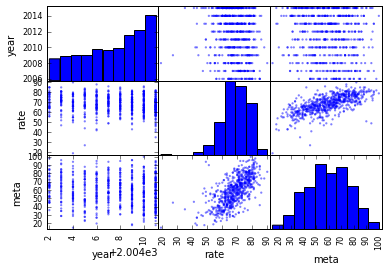

In [112]:
# plot the scatter matrix for attributes in IMDB
fd = pd.plotting.scatter_matrix(IMDB_dataset[['year', 'rate', 'meta']])

(0, 125)

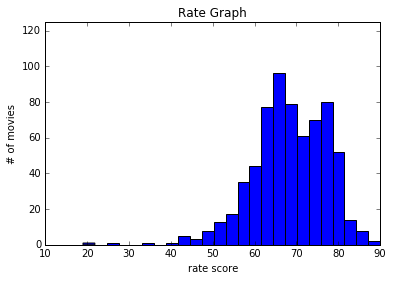

In [113]:
# plot the histogram of rates of movies 
_ = plt.hist(IMDB_dataset['rate'],25)
plt.title("Rate Graph")
plt.xlabel("rate score")
plt.ylabel("# of movies")

f1 = plt.gca()
f1.set_ylim([0,125])

(0, 125)

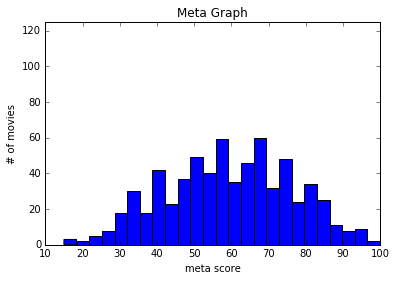

In [114]:
# plot the histogram of metascores of movies 
_ = plt.hist(IMDB_dataset['meta'],25)
plt.title("Meta Graph")
plt.xlabel("meta score")
plt.ylabel("# of movies")

f2 = plt.gca()
f2.set_ylim([0,125])

(0, 1000)

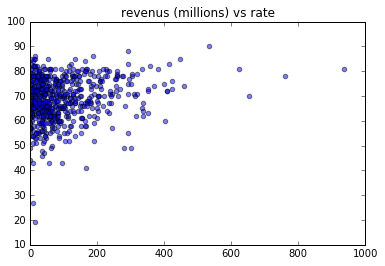

In [115]:
# plot the scatter plot for revenue and rate to see their relation
plt.scatter(IMDB_dataset['revenue'], IMDB_dataset['rate'], alpha=0.5)
plt.title("revenus (millions) vs rate")
f1 = plt.gca()
f1.set_xlim([0,1000])

(0, 1000)

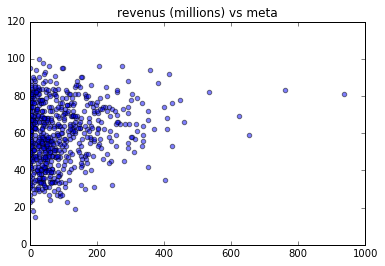

In [116]:
# plot the scatter plot for revenue and metascore to see their relation
plt.scatter(IMDB_dataset['revenue'], IMDB_dataset['meta'], alpha=0.5)
plt.title("revenus (millions) vs meta")
f1 = plt.gca()
f1.set_xlim([0,1000])

In [117]:
# function that calculates the mean of certain attribute of each year
def rateMeanPerYear(colName):
    a = []
    for year in range(2006,2017):
        a.append(IMDB_dataset.loc[IMDB_dataset['year'] == year][colName].mean())
    return a

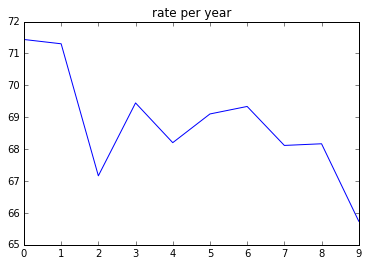

In [118]:
# plot mean rates in each year
plt.plot(rateMeanPerYear('rate'))
plt.title("rate per year") 
f1 = plt.gca()

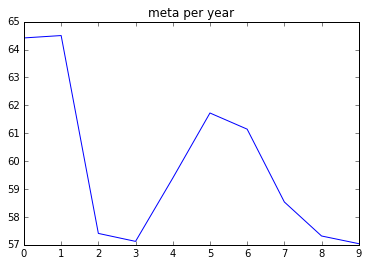

In [119]:
# plot mean metascores in each year
plt.plot(rateMeanPerYear('meta'))
plt.title("meta per year") 
f1 = plt.gca()

### Part 2: Oscar nominated movies

In [120]:
# Basic statistics
rate_stats = Oscar_nominated['rate'].describe()
meta_stats = Oscar_nominated['meta'].describe()
print("------------Oscar_nominated Rate----------\n", rate_stats, "\n")
print("------------Oscar_nominated Meta -----------\n", meta_stats)

------------Oscar_nominated Rate----------
 count    164.000000
mean      75.768293
std        5.705016
min       60.000000
25%       73.000000
50%       77.000000
75%       80.000000
max       90.000000
Name: rate, dtype: float64 

------------Oscar_nominated Meta -----------
 count    164.000000
mean      74.536585
std       12.260161
min       35.000000
25%       67.000000
50%       76.000000
75%       82.250000
max      100.000000
Name: meta, dtype: float64


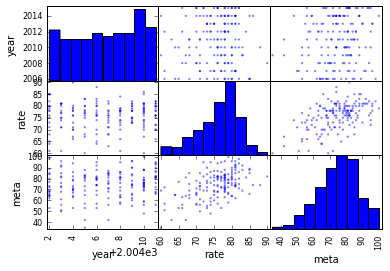

In [121]:
# plot the scatter matrix for attributes in Oscar_nominated dataset
fd = pd.plotting.scatter_matrix(Oscar_nominated[['year', 'rate', 'meta']])

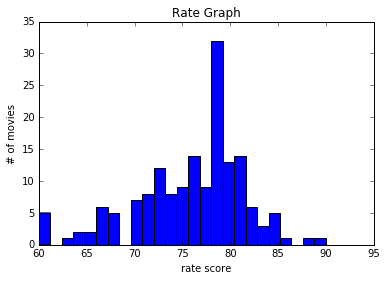

In [122]:
# plot the histogram of rate of oscar nominated movies 
_ = plt.hist(Oscar_nominated['rate'],25)
plt.title("Rate Graph")
plt.xlabel("rate score")
plt.ylabel("# of movies")

f1 = plt.gca()

(0, 12)

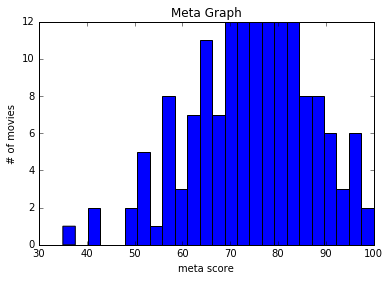

In [123]:
# plot the histogram of metascores of oscar nominated movies 
_ = plt.hist(Oscar_nominated['meta'],25)
plt.title("Meta Graph")
plt.xlabel("meta score")
plt.ylabel("# of movies")

f2 = plt.gca()
f2.set_ylim([0,12])

### Part 3: Oscar winners

In [124]:
# Basic statistics
rate_stats = Oscar_all_winner['rate'].describe()
meta_stats = Oscar_all_winner['meta'].describe()
print("------------Oscar_all_winner Rate----------\n", rate_stats, "\n")
print("------------Oscar_all_winner Meta -----------\n", meta_stats)

------------Oscar_all_winner Rate----------
 count    72.000000
mean     77.750000
std       5.375348
min      61.000000
25%      75.000000
50%      78.000000
75%      81.000000
max      90.000000
Name: rate, dtype: float64 

------------Oscar_all_winner Meta -----------
 count     72.000000
mean      79.569444
std       11.796187
min       51.000000
25%       72.000000
50%       81.000000
75%       88.000000
max      100.000000
Name: meta, dtype: float64


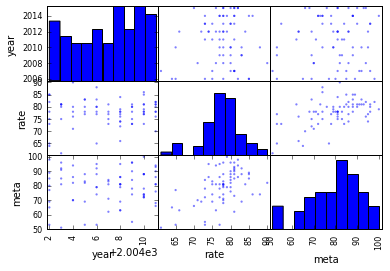

In [125]:
# plot the scatter matrix for attributes in Oscar_all_winner dataset
fd = pd.plotting.scatter_matrix(Oscar_all_winner[['year', 'rate', 'meta']])

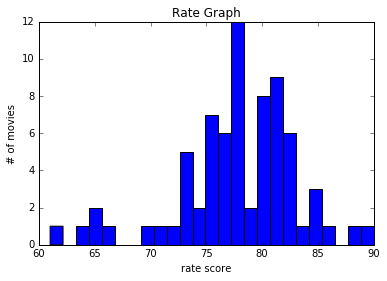

In [126]:
# plot the histogram of rate of oscar winners
_ = plt.hist(Oscar_all_winner['rate'],25)
plt.title("Rate Graph")
plt.xlabel("rate score")
plt.ylabel("# of movies")

f1 = plt.gca()

(0, 12)

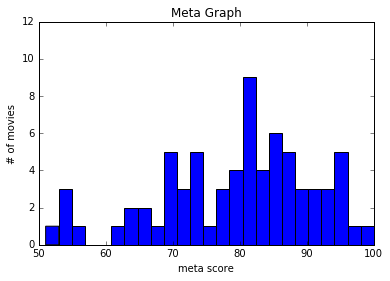

In [127]:
# plot the histogram of metascore of oscar winners
_ = plt.hist(Oscar_all_winner['meta'],25)
plt.title("Meta Graph")
plt.xlabel("meta score")
plt.ylabel("# of movies")

f2 = plt.gca()
f2.set_ylim([0,12])

# Data Analysis and Results

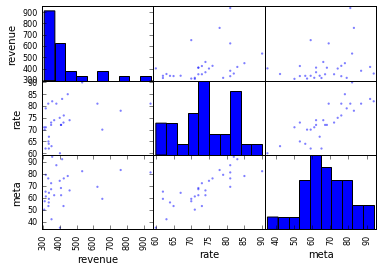

In [128]:
# revenue: meta / rate
avg_rev = IMDB_dataset['revenue'].mean()
std_rev = IMDB_dataset['revenue'].std()

high_rev = avg_rev + 2*std_rev

high_rev_df = IMDB_dataset.loc[IMDB_dataset['revenue'] >= high_rev] 
high_rev_df.reset_index(drop=True,inplace=True)


rate = high_rev_df['rate'].describe()
meta = high_rev_df['meta'].describe()

# print(meta)

fd = pd.plotting.scatter_matrix(high_rev_df[['revenue', 'rate', 'meta']])

In [129]:
# Correlation analysis for high revenue movies
outcome_1, predictors_1 = patsy.dmatrices('meta ~ rate + revenue + duration', high_rev_df)
mod_all = sm.OLS(outcome_1, predictors_1)
res_all = mod_all.fit()
print(res_all.summary())

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     26.03
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           5.41e-08
Time:                        19:12:58   Log-Likelihood:                -100.50
No. Observations:                  30   AIC:                             209.0
Df Residuals:                      26   BIC:                             214.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.9855     15.921     -1.381      0.1

### High Revenue Movies

This data shows that in high revenue movies, meta score and public score are strongly correlated! 
The revenue itself is not correlated with the meta score, but the duration of the movie is. 

In [130]:
# Analyze the influence of the "best picture" award
Oscar_best_pic = pd.DataFrame({})
o1 = Oscars_dataset[Oscars_dataset['award'] == 'Best Picture']

for name, film in zip(o1["name"], o1["film"]):
    Oscar_best_pic = Oscar_best_pic.append(IMDB_dataset[IMDB_dataset["title"] == name])
    Oscar_best_pic = Oscar_best_pic.append(IMDB_dataset[IMDB_dataset["title"] == film])

Oscar_best_pic.drop_duplicates(inplace=True)
Oscar_best_pic.reset_index(drop=True, inplace=True)

Oscar_best_pic.head()

,title,genre,director,actors,year,duration,rate,votes,revenue,meta
0,babel,Drama,Alejandro González Iñárritu,"Brad Pitt, Cate Blanchett, Gael García Bernal,...",2006,143,75.0,253417,34.30,69.0
1,the departed,"Crime,Drama,Thriller",Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...",2006,151,85.0,937414,132.37,85.0
2,little miss sunshine,"Comedy,Drama",Jonathan Dayton,"Steve Carell, Toni Collette, Greg Kinnear, Abi...",2006,101,78.0,374044,59.89,80.0
3,juno,"Comedy,Drama",Jason Reitman,"Ellen Page, Michael Cera, Jennifer Garner, Jas...",2007,96,75.0,432461,143.49,81.0
4,no country for old men,"Crime,Drama,Thriller",Ethan Coen,"Tommy Lee Jones, Javier Bardem, Josh Brolin, W...",2007,122,81.0,660286,74.27,91.0


meta statistics:
count     57.000000
mean      82.684211
std        9.110743
min       53.000000
25%       79.000000
50%       83.000000
75%       88.000000
max      100.000000
Name: meta, dtype: float64
rate statistics:
count    57.000000
mean     78.578947
std       3.535268
min      68.000000
25%      76.000000
50%      78.000000
75%      81.000000
max      88.000000
Name: rate, dtype: float64


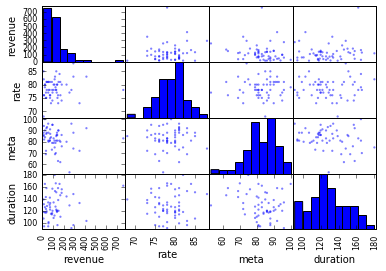

In [131]:
# Statistical analysis
print("meta statistics:")
print(Oscar_best_pic['meta'].describe())
print("rate statistics:")
print(Oscar_best_pic['rate'].describe())

fd = pd.plotting.scatter_matrix(Oscar_best_pic[['revenue', 'rate', 'meta', 'duration']])

In [132]:
# Correlation for "best picture" nominated movies
outcome_1, predictors_1 = patsy.dmatrices('meta ~ rate + revenue + duration', Oscar_best_pic)
mod_all = sm.OLS(outcome_1, predictors_1)
res_all = mod_all.fit()
print(res_all.summary())

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.282
Date:                Thu, 22 Mar 2018   Prob (F-statistic):              0.290
Time:                        19:13:01   Log-Likelihood:                -204.32
No. Observations:                  57   AIC:                             416.6
Df Residuals:                      53   BIC:                             424.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     85.5571     27.674      3.092      0.0

### Best Picture Movies

The lower correlation between the public socres and authority scores is a surprising. We think the reason for it is that authorities tend to be more parallel with the Academy's opinions. The revenue and duration of the movies did not appear to be strongly correlated with the meta scores either. 

In [133]:
# extract the most frequent genre in the imdb dataset, calculate the average metascore and revenue.
popular_genre_dict = dict()

for index, row in IMDB_dataset.iterrows():
    genre_list = row["genre"].split(',')
    for genre in genre_list:
        if genre not in popular_genre_dict:
            if not np.isnan(row["revenue"]):
                popular_genre_dict[genre] = (1,row["meta"], row["revenue"])
            else:
                popular_genre_dict[genre] = (1,row["meta"], 0.0)
        else:
            value = popular_genre_dict[genre]
            if not np.isnan(row["revenue"]):
                popular_genre_dict[genre] = (value[0]+1, value[1]+row["meta"], value[2]+row["revenue"])
            else: 
                popular_genre_dict[genre] = (value[0]+1, value[1]+row["meta"], value[2])
                
for k, v in list(popular_genre_dict.items()):
    newtuple = (v[0], v[1]/v[0], v[2]/v[0])
    popular_genre_dict[k] = newtuple
    if v[0] <= 100:
        del popular_genre_dict[k]
popular_genre = list(popular_genre_dict.items())
print(popular_genre)

[('Adventure', (190, 58.88421052631579, 167.18631578947367)), ('Romance', (102, 54.549019607843135, 45.663039215686304)), ('Comedy', (191, 57.481675392670155, 79.84623036649218)), ('Thriller', (129, 59.333333333333336, 73.90170542635656)), ('Crime', (105, 59.2, 67.75980952380951)), ('Drama', (328, 63.85060975609756, 55.33570121951215)), ('Action', (220, 55.00909090909091, 137.92240909090907))]


                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     96.38
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           2.54e-39
Time:                        19:13:04   Log-Likelihood:                -797.34
No. Observations:                 215   AIC:                             1603.
Df Residuals:                     211   BIC:                             1616.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.7885      7.043     -4.656      0.0

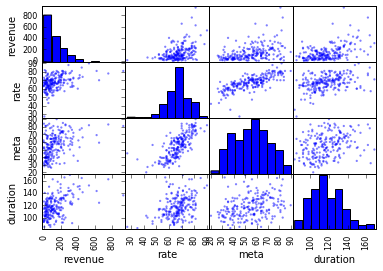

In [134]:
# Analyze the correlation of different attribute in the scope of all action movies
Action_data = IMDB_dataset[IMDB_dataset["genre"].str.contains('Action')]
fd = pd.plotting.scatter_matrix(Action_data[['revenue', 'rate', 'meta', 'duration']])

outcome, predictors = patsy.dmatrices('meta ~ rate + revenue + duration', Action_data)
mod_all = sm.OLS(outcome, predictors)
res_all = mod_all.fit()
print(res_all.summary())

### Actions Movies

The public views toward action movies are strongly correlated with the public views. It is interesting to see there is a strong correlation between the authority scores of the action movie and its revenue. High revenue movies win higher scores. 

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     104.3
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.80e-39
Time:                        19:13:07   Log-Likelihood:                -685.65
No. Observations:                 188   AIC:                             1379.
Df Residuals:                     184   BIC:                             1392.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.0185      6.439     -3.575      0.0

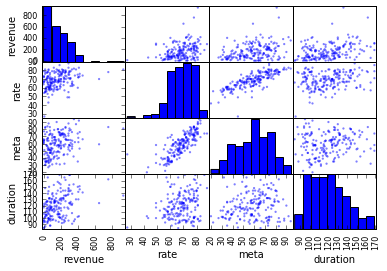

In [135]:
# Analyze the correlation of different attribute in the scope of all adventure movies
Adventure_data = IMDB_dataset[IMDB_dataset["genre"].str.contains('Adventure')]
fd = pd.plotting.scatter_matrix(Adventure_data[['revenue', 'rate', 'meta', 'duration']])

outcome, predictors = patsy.dmatrices('meta ~ rate + revenue + duration', Adventure_data)
mod_all = sm.OLS(outcome, predictors)
res_all = mod_all.fit()
print(res_all.summary())

### Advanture Movies

Similar to the action movies, public views and authority views are strongly correlated. It is interesting to notice that the revenue and the duration of the movies are both correlated with the meta scores.

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     62.80
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           7.07e-28
Time:                        19:13:10   Log-Likelihood:                -720.02
No. Observations:                 185   AIC:                             1448.
Df Residuals:                     181   BIC:                             1461.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.3146      9.048     -3.903      0.0

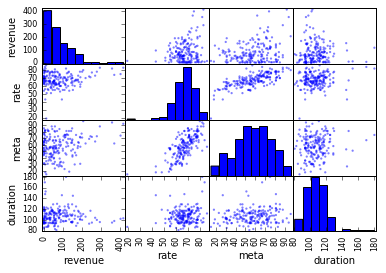

In [136]:
# Analyze the correlation of different attribute in the scope of all comedy movies
Comedy_data = IMDB_dataset[IMDB_dataset["genre"].str.contains('Comedy')]
fd = pd.plotting.scatter_matrix(Comedy_data[['revenue', 'rate', 'meta', 'duration']])

outcome, predictors = patsy.dmatrices('meta ~ rate + revenue + duration', Comedy_data)
mod_all = sm.OLS(outcome, predictors)
res_all = mod_all.fit()
print(res_all.summary())

### Comedy Movies

Similarly, public and meta scores are strongly correlated. However, unlike the action and advanture movies above, the duration is not correlated with the meta scores

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     49.30
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           5.07e-26
Time:                        19:13:12   Log-Likelihood:                -1239.5
No. Observations:                 310   AIC:                             2487.
Df Residuals:                     306   BIC:                             2502.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.9583      7.179     -1.805      0.0

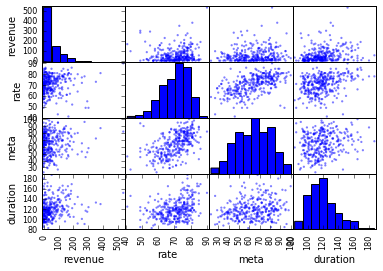

In [137]:
# Analyze the correlation of different attribute in the scope of all drama movies
Drama_data = IMDB_dataset[IMDB_dataset["genre"].str.contains('Drama')]
fd = pd.plotting.scatter_matrix(Drama_data[['revenue', 'rate', 'meta', 'duration']])

outcome, predictors = patsy.dmatrices('meta ~ rate + revenue + duration', Drama_data)
mod_all = sm.OLS(outcome, predictors)
res_all = mod_all.fit()
print(res_all.summary())

### Drama Movies

It confirms the trend that all genres, meta and public scores are suprisingly high correlated.

In [138]:
outcome_1, predictors_1 = patsy.dmatrices('meta ~ rate + revenue + duration', IMDB_dataset)
mod_all = sm.OLS(outcome_1, predictors_1)
res_all = mod_all.fit()
print(res_all.summary())

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     184.1
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           6.23e-86
Time:                        19:13:13   Log-Likelihood:                -2509.1
No. Observations:                 640   AIC:                             5026.
Df Residuals:                     636   BIC:                             5044.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -28.0176      4.310     -6.500      0.0

In [139]:
outcome_2, predictors_2 = patsy.dmatrices('meta ~ rate + revenue + duration', Oscar_nominated)
mod_nominated = sm.OLS(outcome_2, predictors_2)
res_nominated = mod_nominated.fit()
print(res_nominated.summary())

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     29.22
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           4.05e-15
Time:                        19:13:13   Log-Likelihood:                -607.42
No. Observations:                 164   AIC:                             1223.
Df Residuals:                     160   BIC:                             1235.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4366     10.990      0.404      0.6

In [140]:
outcome_2, predictors_2 = patsy.dmatrices('meta ~ rate + revenue + duration', non_nominee)
mod_nominated = sm.OLS(outcome_2, predictors_2)
res_nominated = mod_nominated.fit()
print(res_nominated.summary())
#Todo:
# non-nominee 
#  oscar winning corrolations

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     84.84
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           6.42e-44
Time:                        19:13:13   Log-Likelihood:                -1857.1
No. Observations:                 476   AIC:                             3722.
Df Residuals:                     472   BIC:                             3739.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.7060      5.278     -2.597      0.0

In [141]:
outcome_2, predictors_2 = patsy.dmatrices('meta ~ rate + revenue + duration', Oscar_all_winner)
mod_nominated = sm.OLS(outcome_2, predictors_2)
res_nominated = mod_nominated.fit()
print(res_nominated.summary())

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     13.13
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           7.40e-07
Time:                        19:13:13   Log-Likelihood:                -262.89
No. Observations:                  72   AIC:                             533.8
Df Residuals:                      68   BIC:                             542.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4314     16.791     -0.145      0.8

In [142]:
def nominated(title):
    if title in Oscar_nominated['title'].values:
        return 1.0
    else:
        return 0.0

In [143]:
IMDB_dataset['oscar nominated'] = IMDB_dataset['title'].apply(nominated)
IMDB_dataset['oscar nominated'].value_counts()

0.0    504
1.0    164
Name: oscar nominated, dtype: int64

In [144]:
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize)

In [145]:
MR_tfidf_X = tfidf.fit_transform(IMDB_dataset['actors']).toarray()

LookupError: 
**********************************************************************
  Resource 'tokenizers/punkt/english.pickle' not found.  Please
  use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - 'C:\\Users\\duiba/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:\\Users\\duiba\\Anaconda3\\nltk_data'
    - 'C:\\Users\\duiba\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\duiba\\AppData\\Roaming\\nltk_data'
    - ''
**********************************************************************

In [ ]:
MR_y = IMDB_dataset['oscar nominated'].as_matrix().reshape(668,)
num_training = int(len(IMDB_dataset.index)*0.5)
num_testing = int(len(IMDB_dataset.index)*0.5)
MR_train_tfidf_X = MR_tfidf_X[0:num_training]
MR_train_tfidf_y = MR_y[0:num_training]
MR_test_tfidf_X = MR_tfidf_X[num_training:]
MR_test_tfidf_y = MR_y[num_training:]

In [ ]:
MR_tfidf_clf = train_SVM(MR_train_tfidf_X, MR_train_tfidf_y)

In [ ]:
MR_pred_train_tfidf_y = MR_tfidf_clf.predict(MR_train_tfidf_X)
MR_pred_test_tfidf_y = MR_tfidf_clf.predict(MR_test_tfidf_X)

In [ ]:
print(classification_report(MR_train_tfidf_y, MR_pred_train_tfidf_y))

In [ ]:
print(classification_report(MR_test_tfidf_y, MR_pred_test_tfidf_y))

### Above: IMDB
### Below: Oscar

In [ ]:
# predict oscar winner from actor names
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize)

In [ ]:
MR_tfidf_X = tfidf.fit_transform(Oscars_dataset['film']).toarray()

In [ ]:
MR_y = Oscars_dataset['winner'].as_matrix().reshape(1229,)
num_training = int(len(Oscars_dataset.index)*0.8)
num_testing = int(len(Oscars_dataset.index)*0.2)
MR_train_tfidf_X = MR_tfidf_X[0:num_training]
MR_train_tfidf_y = MR_y[0:num_training]
MR_test_tfidf_X = MR_tfidf_X[num_training:]
MR_test_tfidf_y = MR_y[num_training:]

In [ ]:
MR_tfidf_clf = train_SVM(MR_train_tfidf_X, MR_train_tfidf_y)

In [ ]:
MR_pred_train_tfidf_y = MR_tfidf_clf.predict(MR_train_tfidf_X)
MR_pred_test_tfidf_y = MR_tfidf_clf.predict(MR_test_tfidf_X)

In [ ]:
print(classification_report(MR_train_tfidf_y, MR_pred_train_tfidf_y))

In [ ]:
print(classification_report(MR_test_tfidf_y, MR_pred_test_tfidf_y))

In [ ]:
# predict oscar winner from film names
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize)

In [ ]:
MR_tfidf_X = tfidf.fit_transform(Oscars_dataset['name']).toarray()

In [ ]:
MR_y = Oscars_dataset['winner'].as_matrix().reshape(1229,)
num_training = int(len(Oscars_dataset.index)*0.8)
num_testing = int(len(Oscars_dataset.index)*0.2)
MR_train_tfidf_X = MR_tfidf_X[0:num_training]
MR_train_tfidf_y = MR_y[0:num_training]
MR_test_tfidf_X = MR_tfidf_X[num_training:]
MR_test_tfidf_y = MR_y[num_training:]

In [ ]:
MR_tfidf_clf = train_SVM(MR_train_tfidf_X, MR_train_tfidf_y)

In [ ]:
MR_pred_train_tfidf_y = MR_tfidf_clf.predict(MR_train_tfidf_X)
MR_pred_test_tfidf_y = MR_tfidf_clf.predict(MR_test_tfidf_X)

In [ ]:
print(classification_report(MR_train_tfidf_y, MR_pred_train_tfidf_y))

In [ ]:
print(classification_report(MR_test_tfidf_y, MR_pred_test_tfidf_y))

In [ ]:
# predict meta score from vote
a1, a2, a3, a4, b = np.polyfit(IMDB_dataset['votes'], IMDB_dataset['meta'], 4)
def predict_meta_from_vote(r):
    return r*r*r*r*a1+r*r*r*a2+r*r*a3+r*a4+b

In [ ]:
print(predict_meta_from_vote(1000000))

# Privacy/Ethics Considerations
The dataset is provided publicly on the website of kaggle, so we assume that we have the permission of using it. We do not find any privacy concerns about these datasets according to the Safe Harbour rules. The information of the movies are public, so there is no concern about privacy. The personal information, such as names, emails of the raters are not provided by these datasets.

We think there are 3 main bias from exploring the preview of this dataset: 
The limitation of language, time period and the ratings themselves. 
Firstly, more than 70% of the movies are English speaking movies, which exclude parts of movies in other language. The similar problem also exists in the rater side. As an English-based website, IMDb fails to include the opinion of peoples from non-English speaking countries. 

Secondly, almost all selected movies are produced between 2006 and 2016, which exclude movies produced in 20 century. However, these movies consist a considerable large portion of the top 50 rated movie list on IMDB website. 

Thirdly, since IMDb is a public site that everyone can edit and comment, it is possible that some high-rating movies are rated by a group of fans and they might sabotage the accuracy of the rating. 

# Conclusions and Discussion


It turns out that our hypotheses are actually wrong, Oscars awards are matching up with the public reviews in IMDb quite well. More specifically, the normal people tends to give a relatively higher rate overall, while the critics give relatively lower rates overall. It is a good sign that Academy is in touch with the public. Thus, Oscars are indeed an important indication of movies merit. After we extract all movies of the same genre and high revenue, we do not see a large difference in the correlation between Oscar winning and rating, which lead to our conclusion that genre and revenue are not strong indicators in winning Oscar. 

In addition, we built a predictor, predicting if a movie can win Oscar given the actors name in that movie. As a fun fact, the accuracy of the predictor is not very good and we can somehow see that having certain actors in the cast list does not necessarily give a movie higher possibility in winning Oscar. 

Some of the drawbacks of our analysis are that IMDb is only one of the rating platforms, it is almost impossible to represent the whole group of movie viewers, as people of different tastes might be inclined to different rating platforms, like rotten tomatoes and etc. Hence, we expect our data to be biased.
We also need to take into account the number of people that are rating a particular movie. If, say, a movie only received roughly 20 reviews or ratings,  it is very likely that this rating is inaccurate and we may want to drop this ratings to ensure our accuracy. 
